In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy import signal
from scipy.integrate import simps
from scipy import signal
from sklearn.decomposition import FastICA

import torch
import torch.nn as nn

import dataloader as dl

## Load data

In [16]:
fileName = '110414'
EEG = sio.loadmat('./Data_Python/%s.mat'%(fileName))
data = EEG['data']
events = EEG['event']
chanlocs = EEG['chanlocs']
print('Shape of data ', data.shape)
print('Shape of events ', events.shape)
print('Shape of chanlocs ', chanlocs.shape)

Shape of data  (128, 596145)
Shape of events  (321, 2)
Shape of chanlocs  (1, 128)


In [17]:
# Extract channel label, theta, arc length
num_channel = chanlocs.shape[1]
chan_label, chan_theta, chan_arc_length = [], [], []

for i in range(num_channel):
    chan_label.append(chanlocs[0,i][0][0])
    chan_theta.append(chanlocs[0,i][1][0,0])
    chan_arc_length.append(chanlocs[0,i][2][0,0])
    
# create dataframe for them
d = {'label':chan_label, 'theta':chan_theta, 'arc_length':chan_arc_length}
channels = pd.DataFrame(data=d)

In [22]:
channels.to_csv('./Channel_coordinate/%s_channels.csv'%(fileName))

In [23]:
A = pd.read_csv('./Channel_coordinate/%s_channels.csv'%(fileName))

In [25]:
A = [1,3,5]

In [26]:
for i, a in enumerate(A):
    print(i)
    print(a)

0
1
1
3
2
5


In [29]:
events

array([[array([[0.5]]), array(['0'], dtype='<U1')],
       [array([[256]], dtype=uint16), array(['505'], dtype='<U3')],
       [array([[773.5]]), array(['3'], dtype='<U1')],
       [array([[2644.5]]), array(['501'], dtype='<U3')],
       [array([[2900]], dtype=uint16), array(['0'], dtype='<U1')],
       [array([[3027.5]]), array(['505'], dtype='<U3')],
       [array([[3542]], dtype=uint16), array(['1'], dtype='<U1')],
       [array([[6634.5]]), array(['501'], dtype='<U3')],
       [array([[6890]], dtype=uint16), array(['0'], dtype='<U1')],
       [array([[7017.5]]), array(['505'], dtype='<U3')],
       [array([[7531]], dtype=uint16), array(['2'], dtype='<U1')],
       [array([[8205.5]]), array(['501'], dtype='<U3')],
       [array([[8461]], dtype=uint16), array(['0'], dtype='<U1')],
       [array([[8588.5]]), array(['505'], dtype='<U3')],
       [array([[9103.5]]), array(['1'], dtype='<U1')],
       [array([[9764.5]]), array(['501'], dtype='<U3')],
       [array([[10020]], dtype=uint16

In [24]:
A

,Unnamed: 0,label,theta,arc_length
0,0,A1,-27.224712,0.469855
1,1,A2,-35.351458,0.481330
2,2,A3,-33.804159,0.524365
3,3,A4,-41.068033,0.374972
4,4,A5,-48.141936,0.416668
...,...,...,...,...
123,123,D28,151.815690,0.551752
124,124,D29,135.795161,0.572686
125,125,D30,-134.479988,0.519932
126,126,D31,-148.339104,0.571811


## Epoch data

In [4]:
sampling_rate = 256
num_epoch_1 = sum([1 if x[1]=='1' else 0 for x in events])
num_epoch_2 = sum([1 if x[1]=='2' else 0 for x in events])
num_epoch_3 = sum([1 if x[1]=='3' else 0 for x in events])
X1 = np.zeros((num_epoch_1, num_channel, sampling_rate*2))
Y1 = np.zeros(num_epoch_1)
X2 = np.zeros((num_epoch_2, num_channel, sampling_rate*2))
Y2 = np.zeros(num_epoch_2)
X3 = np.zeros((num_epoch_3, num_channel, sampling_rate*2))
Y3 = np.zeros(num_epoch_3)
print('Number of event 1: ', num_epoch_1)
print('Number of event 2: ', num_epoch_2)
print('Number of event 3: ', num_epoch_3)

Number of event 1:  20
Number of event 2:  33
Number of event 3:  12


In [11]:
iter_event = np.zeros(3).astype('int')
for i in range(events.shape[0]):
    event = events[i]
    event_time = int(event[0])
    event_type = event[1]
    
    # Event 1
    if event_type == '1':
        X1[iter_event[0],:,:] = data[:, event_time-2*sampling_rate:event_time]
        Y1[iter_event[0]] = int(events[i+1,0] - event_time)/sampling_rate
        iter_event[0] += 1
    # Event 2
    elif event_type == '2':
        X2[iter_event[1],:,:] = data[:, event_time-2*sampling_rate:event_time]
        Y2[iter_event[1]] = int(events[i+1,0] - event_time)/sampling_rate
        iter_event[1] += 1
    # Event 3
    elif event_type == '3':
        X3[iter_event[2],:,:] = data[:, event_time-2*sampling_rate:event_time]
        Y3[iter_event[2]] = int(events[i+1,0] - event_time)/sampling_rate
        iter_event[2] += 1
        
print('Shape of X1: ', X1.shape)
print('Shape of X2: ', X2.shape)
print('Shape of X3: ', X3.shape)

Shape of X1:  (20, 21, 512)
Shape of X2:  (33, 21, 512)
Shape of X3:  (12, 21, 512)


## Bandpower example (Separate)

In [2]:
X, Y = dl.read_data([1,2,3])

Event 1 X shape:  (324, 21, 512)
Event 2 X shape:  (546, 21, 512)
Event 3 X shape:  (226, 21, 512)
Combined X shape:  (1096, 21, 512)


(512,)
(65,)
(65,)


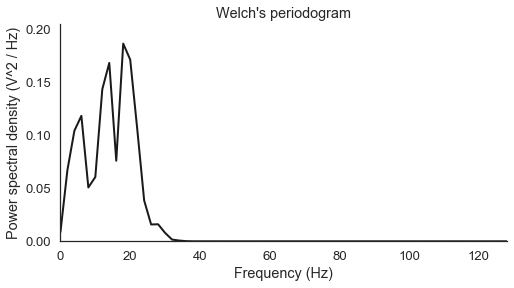

In [7]:
fs = 256
sample = X[525,12,:]
print(sample.shape)
# Define window length
win = 0.5*fs
freqs, psd = signal.welch(sample, fs, nperseg=win, noverlap=win/2)
print(freqs.shape)
print(psd.shape)

# Plot the power spectrum

sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()


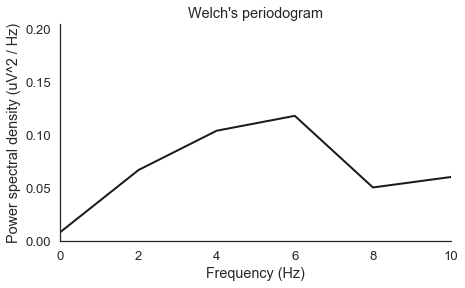

In [12]:
# Define lower and upper bounds
low, high = 13, 30

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [13]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_theta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 1.332 uV^2


## Calculate theta, alpha, beta bandpower (Together)

In [2]:
X, Y = dl.read_data([1,2,3])
fs = 256
# Define window length
win = 0.5*fs
freqs, psd = signal.welch(X, fs, nperseg=win, noverlap=win/2)
print(freqs.shape)
print(psd.shape)

Event 1 X shape:  (324, 21, 512)
Event 2 X shape:  (546, 21, 512)
Event 3 X shape:  (226, 21, 512)
Combined X shape:  (1096, 21, 512)
(65,)
(1096, 21, 65)


In [3]:
# Define lower and upper bounds
low, high = [4,7,13], [7,13,30]

# Find intersecting values in frequency vector
idx = np.logical_and(freqs[:,np.newaxis] >= low, freqs[:,np.newaxis] <= high)
idx = idx.T   # (65,3)->(3,65)

In [5]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1/0.5 = 2

# Compute the absolute power by approximating the area under the curve
powers = np.zeros((X.shape[0],X.shape[1],3))
for i in range(3):
    idx_power = idx[i,:]
    powers[:,:,i] = simps(psd[:,:,idx_power], dx=freq_res)

print(powers.shape)

(1096, 21, 3)


In [6]:
print('Absolute theta power: %.3f uV^2' % powers[525, 12, 0])
print('Absolute alpha power: %.3f uV^2' % powers[525, 12, 1])
print('Absolute beta power: %.3f uV^2' % powers[525, 12, 2])

Absolute theta power: 0.222 uV^2
Absolute alpha power: 0.291 uV^2
Absolute beta power: 1.332 uV^2


## Test Dataloder

In [5]:
import network_dataloader as ndl
import torch
from torchvision import models, transforms
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [2]:
batchSize = 10
input_size = 224
# Load Data
data_transforms = {
        'train': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()]), 
        'test': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()])
        }

print("Initializing Datasets and Dataloaders...")

# Create training and testing datasets
image_datasets = {x: ndl.TopoplotLoader('images', x, data_transforms[x]) for x in ['train', 'test']}

# Create training and testing dataloaders
dataloaders_dict = {'train': Data.DataLoader(image_datasets['train'], batch_size=batchSize, shuffle=True, num_workers=4),
                    'test':  Data.DataLoader(image_datasets['test'], batch_size=batchSize, shuffle=False, num_workers=4)}

Initializing Datasets and Dataloaders...
> Found 58 images...
> Found 7 images...


In [3]:
for samples in dataloaders_dict['test']:
    print(samples['image'].shape)
    print(samples['label'])

torch.Size([7, 3, 224, 224])
tensor([ 26.4258,  23.5195,   7.3984,   9.4297,   5.9844, 170.8711,   4.7344])


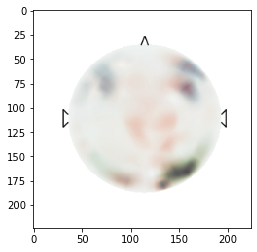

In [14]:
image = samples['image'][0].numpy().transpose((1,2,0))
plt.imshow(image)

# Transform ICA into neural network

In [84]:
class ICANN(nn.Module):
    
    def __init__(self, num_channel, V_weight, W_weight, V_bias):
        super(ICANN, self).__init__()
        self.V = nn.Linear(num_channel, num_channel)
        self.W = nn.Linear(num_channel, num_channel, bias=False)
        
        # Initialize V by whitenting matrix and W by unmixing matrix
        with torch.no_grad():
            # Weight in Linear: (out_features, in_features)
            self.V.weight = nn.Parameter(torch.FloatTensor(V_weight))
            self.W.weight = nn.Parameter(torch.FloatTensor(W_weight))
            self.V.bias = nn.Parameter(torch.FloatTensor(V_bias))
        self.V.weight.requires_grad = False
        self.W.weight.requires_grad = False
        self.V.bias.requires_grad=False
        
    def forward(self, x):
        
        # Dimension of x: (batch, time, channel)
        
        x = self.V(x)
        x = self.W(x)
        
        return x
        
def icann(data):
    
    # Shape of data: (time, channel)
    num_channel = data.shape[1]
    ica = FastICA(n_components=num_channel, random_state=23)
    ica.fit(data)
    
    unmixing_matrix = ica.components_.dot(np.linalg.inv(ica.whitening_))
    bias = -ica.whitening_.dot(ica.mean_)
    
    return ICANN(num_channel, ica.whitening_, unmixing_matrix, bias)
    

Shape of S: (2000, 3), Shape of X: (2000, 3)


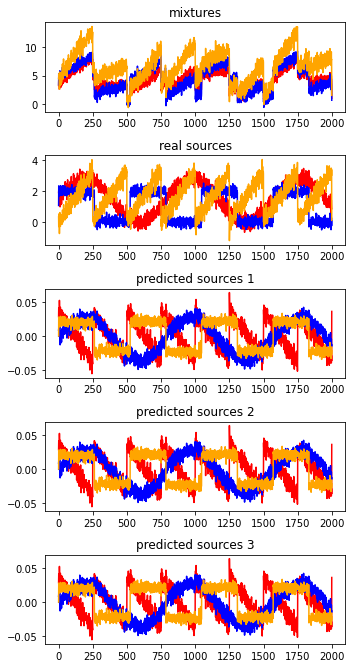

In [86]:
# Generate source signal
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)+1
s2 = np.sign(np.sin(3 * time))+1
s3 = signal.sawtooth(2 * np.pi * time)+1
S = np.c_[s1, s2, s3]

# Add noise
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)

# Mix source signal
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
X = np.dot(S, A.T)
print('Shape of S: %s, Shape of X: %s'%(S.shape, X.shape))

# Use ICA to seperate them
ica = FastICA(n_components=3, random_state=23)
ica.fit(X)
S_1 = ica.transform(X)

unmixing_matrix = ica.components_.dot(np.linalg.inv(ica.whitening_))
#S_2 = unmixing_matrix.dot(ica.whitening_).dot((X-ica.mean_).T).T
#S_2 = (X-ica.mean_).dot(ica.whitening_.T).dot(unmixing_matrix.T)
S_2 = (X.dot(ica.whitening_.T)-ica.whitening_.dot(ica.mean_)).dot(unmixing_matrix.T)

icann_model = icann(X)
X_tensor = torch.FloatTensor(X.reshape((1,X.shape[0],X.shape[1])))
S_3 = icann_model(X_tensor).detach().numpy()
S_3 = S_3.reshape((S_3.shape[1],-1))

fig = plt.figure(figsize=(5,11))
models = [X, S, S_1,S_2, S_3]
names = ['mixtures', 'real sources', 'predicted sources 1', 'predicted sources 2', 'predicted sources 3']
colors = ['red', 'blue', 'orange']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(6, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)

fig.tight_layout()        
plt.show()

# Test if rnn can classify three sine waves
https://datascience.oneoffcoder.com/rnn-classify-signals.html

In [2]:
def random_sin(a, f, p, start, stop, n, e_mean=0.0, e_var=0.02):
    """
    Gets a sine wave according to y(t) = a sin(2*pi*f*t + p) + e, where

    * a = amplitude
    * f = frequency
    * t = time
    * p = phase
    * e = error ~ N(e_mean, e_var); error is normally distributed with mean e_mean and variance e_var.

    :param a: Amplitude.
    :param f: Frequency.
    :param p: Phase.
    :param start: Start time (inclusive).
    :param stop: Stop time (inclusive).
    :param n: Number of samples to generate between start and stop.
    :param e_mean: Error mean.
    :param e_var: Error variance.
    :return: Sine wave.
    """

    def sin_of(a, f, p, t, e_mean=0.0, e_var=0.02):
        """
        Gets a sine wave according to y(t) = a sin(2*pi*f*t + p) + e, where

        * a = amplitude
        * f = frequency
        * t = time
        * p = phase
        * e = error ~ N(e_mean, e_var); error is normally distributed with mean e_mean and variance e_var.

        :param a: Amplitude.
        :param f: Frequency.
        :param p: Phase.
        :param t: Time.
        :param e_mean: Error mean.
        :param e_var: Error variance.
        :return: Sine wave.
        """
        return a * np.sin(2 * np.pi * f * t + p) + np.random.normal(e_mean, e_var)

    return np.array([[t, sin_of(a, f, p, t, e_mean, e_var)] for t in np.linspace(start, stop, n)], dtype=np.float)

def get_sin_samples(a, f, p, start, stop, n, total=100, e_mean=0.0, e_var=0.02):
    """
    Gets a sample of sine waves according to y(t) = a sin(2*pi*f*t + p) + e, where

    * a = amplitude
    * f = frequency
    * t = time
    * p = phase
    * e = error ~ N(e_mean, e_var); error is normally distributed with mean e_mean and variance e_var.

    :param a: Amplitude.
    :param f: Frequency.
    :param p: Phase.
    :param start: Start time (inclusive).
    :param stop: Stop time (inclusive).
    :param n: Number of samples to generate between start and stop.
    :param total: Total number of samples.
    :param e_mean: Error mean.
    :param e_var: Error variance.
    :return: A sample of sine waves.
    """
    return [random_sin(a, f, p, start, stop, n, e_mean, e_var) for i in range(100)]

Text(0, 0.5, '$y(t)$')

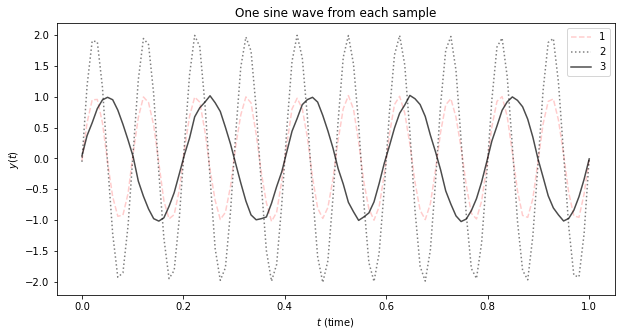

In [3]:
n = 100
total = 100

samples1 = get_sin_samples(a=1, f=10, p=0, start=0, stop=1, n=n, total=total)
samples2 = get_sin_samples(a=2, f=10, p=0, start=0, stop=1, n=n, total=total)
samples3 = get_sin_samples(a=1, f=5, p=0, start=0, stop=1, n=n, total=total)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(samples1[0][:, 0], samples1[0][:, 1], 'r--', label='1', alpha=0.2)
ax.plot(samples2[0][:, 0], samples2[0][:, 1], 'k:', label='2', alpha=0.5)
ax.plot(samples3[0][:, 0], samples3[0][:, 1], 'k', label=3, alpha=0.7)
ax.legend()
ax.set_title('One sine wave from each sample')
ax.set_xlabel(r'$t$ (time)')
ax.set_ylabel(r'$y(t)$')

In [4]:
x1 = np.array([samples1[i][:, 1] for i in range(len(samples1))], dtype=np.float)
x2 = np.array([samples2[i][:, 1] for i in range(len(samples2))], dtype=np.float)
x3 = np.array([samples3[i][:, 1] for i in range(len(samples3))], dtype=np.float)
y1 = np.full((total, 1), 0)
y2 = np.full((total, 1), 1)
y3 = np.full((total, 1), 2)

X = np.vstack([x1, x2, x3])
y = np.vstack([y1, y2, y3])

print(X.shape)
print(y.shape)

(300, 100)
(300, 1)


In [5]:
def signal_to_tensor(s):
    """
    Converts a signal to a tensor of type float with n x 1 x n dimension.

    :param s: A sine signal.
    :return: A float tensor.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    n = len(s)
    tensor = torch.zeros(n, 1, n, dtype=torch.float, device=device)
    for t, y in enumerate(s):
        tensor[t][0][t] = y
    return tensor

def category_to_tensor(y):
    """
    Converts a category/class label to a tensor of type long with 1 x 1 dimension.

    :param y: A label.
    :return: A long tensor.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    return torch.tensor([y], dtype=torch.long, device=device)

def random_example(X, y):
    """
    Picks a random sample from X and y. Note that X and y are numpy arrays
    but the returned values will be tensors.

    :param X: Matrix of sine waves.
    :param y: Matrix of labels.
    :return: A random sample from X, y that are tensors.
    """
    idx = np.random.randint(low=0, high=X.shape[0]-1)
    return get_example(X, y, idx)

def get_example(X, y, idx):
    """
    Selects the sample specified by `idx` and converts it to a pair of tensors.

    :param X: Matrix of sine waves.
    :param y: Matrix of labels.
    :param idx: Index (or row) of the matrices to convert.
    :return: A pair of tensors from X, y.
    """
    X_ex = X[idx, :]
    y_ex = y[idx, 0]

    X_tensor = signal_to_tensor(X_ex)
    y_tensor = category_to_tensor(y_ex)

    return X_tensor, y_tensor

def train_one(X, y, rnn, criterion, learning_rate):
    """
    Does training on one sample.

    :param X: A tensor representing a sine wave.
    :param y: A tensor representing a label.
    :param rnn: A RNN model.
    :param criterion: Loss function.
    :param learning_rate: Learning rate.
    :return: Returns the output prediction and loss.
    """
    hidden = rnn.initHidden()

    rnn.zero_grad()
    for i in range(X.size()[0]):
        output, hidden = rnn(X[i], hidden)

    loss = criterion(output, y)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, data, hidden):
        combined = torch.cat((data, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        return torch.zeros(1, self.hidden_size, device=device)
    
def train_loop(X, y, rnn, criterion, learning_rate):
    """
    Does training on one sample.

    :param X: A tensor representing a sine wave.
    :param y: A tensor representing a label.
    :param rnn: A RNN model.
    :param criterion: Loss function.
    :param learning_rate: Learning rate.
    :return: Returns the output prediction and loss.
    """
    hidden = rnn.initHidden()

    rnn.zero_grad()
    output, hidden = rnn(X, hidden)

    loss = criterion(output, y)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()
    
class RNN_LOOP(nn.Module):
    '''
    Train the entire sequence at a time
    '''
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LOOP, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, data, hidden):
        
        for data_t in data:
            combined = torch.cat((data_t, hidden), 1)
            hidden = self.i2h(combined)
            
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        return torch.zeros(1, self.hidden_size, device=device)
        
        

In [25]:
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
input_size = n
n_hidden = 128
output_size = 3
mode = 'one'

if mode == 'one':
    rnn = RNN(input_size, n_hidden, output_size)
elif mode == 'loop':
    rnn = RNN_LOOP(input_size, n_hidden, output_size)
rnn = rnn.to(device)

criterion = nn.NLLLoss()
learning_rate = 0.005

n_iters = 1000
plot_every = 5

current_loss = 0
losses = []
iters = []

for i in tqdm(range(1, n_iters + 1)):
    X_tensor, y_tensor = random_example(X, y)
    X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)
    if mode == 'one':
        output, loss = train_one(X_tensor, y_tensor, rnn, criterion, learning_rate)
    elif mode == 'loop':
        output, loss = train_loop(X_tensor, y_tensor, rnn, criterion, learning_rate)
    current_loss += loss

    if i % plot_every == 0:
        losses.append(current_loss / plot_every)
        iters.append(i)
        current_loss = 0

100%|██████████| 1000/1000 [00:21<00:00, 46.52it/s]


Text(0, 0.5, 'loss')

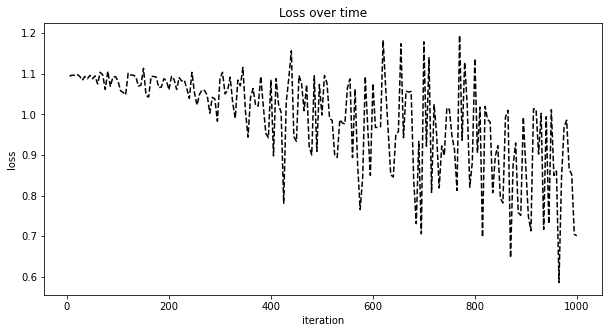

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(iters, losses, 'k--')
ax.set_title('Loss over time')
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'loss')

In [27]:
def evaluate(X, rnn, mode):
    hidden = rnn.initHidden()
    if mode == 'one':
        for i in range(X.size()[0]):
            output, hidden = rnn(X[i], hidden)
    elif mode == 'loop':
        output, hidden = rnn(X, hidden)

    return output

def predict(X, rnn, n_predictions=3, mode='one'):
    with torch.no_grad():
        output = evaluate(X, rnn, mode)

        topv, topi = output.topk(n_predictions, 1, True)
        probs = np.zeros((1, n_predictions))

        for i in range(n_predictions):
            v = output[0][i].item()
            c = output[0][i].item()
            e = np.exp(v)
            probs[0][i] = e

        probs = probs / np.sum(probs)
        return probs

def predict_all(X, y, rnn, n_predictions=3, mode='one'):
    y_pred = np.zeros((X.shape[0], n_predictions))
    y_true = np.zeros((X.shape[0], n_predictions))

    for r in range(X.shape[0]):
        p = predict(signal_to_tensor(X[r, :]), rnn, mode=mode)
        for c in range(n_predictions):
            y_pred[r, c] = p[0, c]
        y_true[r, y[r]] = 1.0
    return y_true, y_pred

In [28]:
y_true, y_pred = predict_all(X, y, rnn, mode=mode)

from sklearn.metrics import brier_score_loss, roc_auc_score, coverage_error
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss

bscore0 = brier_score_loss(y_true[:, 0], y_pred[:, 0])
bscore1 = brier_score_loss(y_true[:, 1], y_pred[:, 1])
bscore2 = brier_score_loss(y_true[:, 2], y_pred[:, 2])

print('> Brier score')
print(f'{bscore0:.5f}: class 0')
print(f'{bscore1:.5f}: class 1')
print(f'{bscore2:.5f}: class 2')

cov_err = coverage_error(y_true, y_pred)
avg_pre = label_ranking_average_precision_score(y_true, y_pred)
rank_loss = label_ranking_loss(y_true, y_pred)

print('')
print('> Multilabel ranking metrics')
print(f'{cov_err:.5f}: coverage error')
print(f'{avg_pre:.5f}: label ranking average precision score')
print(f'{rank_loss:.5f}: label ranking loss')

> Brier score
0.20893: class 0
0.12887: class 1
0.17908: class 2

> Multilabel ranking metrics
1.75333: coverage error
0.65222: label ranking average precision score
0.37667: label ranking loss
